In [18]:
import os,sys,glob,time
smodelsPath = os.path.expanduser('~/smodels')
sys.path.append(smodelsPath)
from smodels.theory.auxiliaryFunctions import rescaleWidth, unscaleWidth
import numpy as np
from trimRegularGrid import trim1D, testTrimmedGrid, removeWidth, trimGrid
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.spatial import ConvexHull,Delaunay,qhull
from scipy.interpolate import griddata, LinearNDInterpolator
import progressbar
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
def interp(point,tri,values):
    
    simplex = tri.find_simplex(point)
    if simplex==-1: ## not inside any simplex?
        return np.nan
    
    simplexTrans = np.take(tri.transform, simplex, axis=0)
    #Space dimension:
    d = simplexTrans.shape[-1]
    #Rotation and translation to baryocentric coordinates:
    delta_x = simplexTrans[d,:]
    rot = simplexTrans[:d,:]
    bary = np.dot(rot,point-delta_x) #Point coordinates in the baryocentric system
    #Weights for the vertices:
    wts = np.append(bary, 1. - bary.sum())
    #Vertex indices:
    vertices = np.take(tri.simplices, simplex, axis=0)
    #Compute the value:
    ret = np.dot(np.take(values, vertices),wts)
    return ret

def point_in_hull(point, hull, tolerance=1e-5):
    return all(
        (np.dot(eq[:-1], point) + eq[-1] <= tolerance)
        for eq in hull.equations)
    
def getMinimumConvexHull(tri):

    #Get full convex hull
    cHullvertices = list(set(tri.convex_hull.flatten()))

    #Start with full hull and remove each point if it does
    #not affect the area covered by the hull:
    newIndices = np.array(cHullvertices)
    for i in cHullvertices:
        #Remove i-th point from full hull
        newIndices = newIndices[newIndices != i]
        newCHull = ConvexHull(tri.points[newIndices])
        keepPoint = False
        for j,pt in enumerate(tri.points[cHullvertices]):
            if j in newIndices:
                continue
            if not point_in_hull(pt,newCHull):
                keepPoint = True
                break
        if keepPoint:
            newIndices = np.append(newIndices,i)
    
    return newIndices

In [11]:
ds = SR = 'SR1FULL_175'
tx = 'THSCPM3'

ntries = 1
gridSize = []
maxError = []
dataFile = '%s_eff_mutrig_%s_trimmedWidth.dat' %(tx,ds)
valueLabel = ds
#Get data
data = np.genfromtxt(dataFile,names=True)
if 'width' in data.dtype.names:
    data['width'] = np.array([rescaleWidth(w) for w in data['width']])

#Pre-select data:
# data = data[(data['width'] < 40) & (data['mhscp'] < 1000)]
# data = data[(data['width'] > 20)]

In [12]:
xy = np.array([list(x) for x in data[['mprod','mhscp','width']]])
yvals = data[SR]

In [44]:
def trimGridTest(points,values,minY = 1e-2,maxDiff = 5e-2):

    t0 = time.time()

    #Replace all small values by minY:
    values = np.where(values > minY,values,minY)
    #Get triangulation:
    tri = Delaunay(points)
    #Get minimum convex hull
#     cHullvertices = list(set(getMinimumConvexHull(tri)))
#     print('cHull size trimmed down to %1.2f%% (%i/%i) in %1.1f min' %(100.0*len(cHullvertices)/len(tri.convex_hull),
#                                                      len(cHullvertices),
#                                                      len(tri.convex_hull),(time.time()-t0)/60.0))
    
    cHullvertices = list(set(tri.convex_hull.flatten()))
    #Get infor about neighbors:
    indptr,indices = tri.vertex_neighbor_vertices
    
    #First compute the maximum (relative) gradient at each point:
    gradients = []
    for i,pt in enumerate(tri.points):
        #Get the neighbors to the point
        neighbors = indices[indptr[i]:indptr[i+1]]
        if len(neighbors) == 0:
            gradients.append(0.0)
            continue
        #Compute the gradient in each direction:
        deltaY = np.abs(values[i]-values[neighbors])
        deltaX = np.array([np.linalg.norm(pt-tri.points[ii]) for ii in neighbors])
        grad = deltaY/deltaX
        gradients.append(grad.max()/values[i])
    gradients = np.array(gradients)
    
    #Get indices of points with the largest gradients coming first
    indexGrad = np.arange(len(points))[np.argsort(gradients)[::-1]]
    
    #Now start with the point with largest gradient + convexHull:
    iStart = indexGrad[0]
    indexKeep = set(cHullvertices[:])
    indexKeep.add(iStart)
    indexKeep = sorted(list(indexKeep))
    checkedPts = set(indexKeep[:])
    
    #Create an additional grid with the possibility for adding points:
    triNew = Delaunay(points[indexKeep],incremental=True)
    valuesNew = values[indexKeep]
    indexKeep = set(indexKeep)
    
    pb = progressbar.ProgressBar(widgets=["checking point ",progressbar.Counter(),
            "/%d " % len(points), progressbar.Percentage(),
            progressbar.Bar( marker=progressbar.RotatingMarker() ),
            progressbar.AdaptiveETA()])
    pb.maxval = len(points)
    pb.start()
    
    
    #At each point check if interpolation at its original neighbors requires adding the neighbor:    
    currentNeighbors = indices[indptr[iStart]:indptr[iStart+1]]
    while len(checkedPts) < len(points):
        pb.update(len(checkedPts))
        nextNeighbors = set()
        for i in currentNeighbors:
            checkedPts.add(i)
            nextNeighbors = nextNeighbors.union(indices[indptr[i]:indptr[i+1]])
            pt = tri.points[i]
            y_interp = max(minY,interp(pt,triNew,valuesNew)) #If interpolation is smaller than minY, set it to minY
            y = values[i]
            diff = abs(y_interp-y)/y #Relative difference            
            if diff > maxDiff:
                indexKeep.add(i)
                #Try adding point, if it fails, start from scratch
                try:
                    triNew.add_points([pt])
                except qhull.QhullError:
                    triNew = Delaunay(points[list(indexKeep)],incremental=True)
                valuesNew = np.hstack((valuesNew,[values[i]]))
        currentNeighbors = nextNeighbors        

    pb.finish()        
    print('Data successfully trimmed down to %1.0f%% (%i/%i) in %1.1f min' %(100.0*len(indexKeep)/len(points),
                                                                                  len(indexKeep),len(points),
                                                                             (time.time()-t0)/60.))
        
    return list(indexKeep)


In [ ]:
minValue = 1e-8
maxDiff=0.05
keepPts = trimGridTest(xy,yvals,maxDiff=maxDiff,minY=minValue)

In [34]:
i = 280
indexKeep= {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 370, 371, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1467, 1468, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1737, 1738, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1979, 1980, 1981, 1994, 1995, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2233, 2234, 2248, 2249, 2262, 2263, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2448, 2449, 2450, 2452, 2453, 2456, 2457, 2458, 2470, 2471, 2484, 2485, 2498, 2499, 2512, 2513, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2561, 2562, 2574, 2575, 2587, 2588, 2600, 2601, 2613, 2614, 2626, 2627, 2640, 2641, 2643, 2644, 2647, 2648, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2691, 2692, 2704, 2705, 2717, 2718, 2731, 2732, 2745, 2746, 2758, 2759, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2809, 2810, 2822, 2823, 2835, 2836, 2848, 2849, 2861, 2862, 2874, 2875, 2887, 2888, 2899, 2900, 2911, 2912, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2931, 2932, 2936, 2937, 2949, 2950, 2962, 2963, 2964, 2965, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 3001, 3002, 3015, 3016, 3028, 3029, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3080, 3081, 3093, 3094, 3106, 3107, 3119, 3120, 3132, 3133, 3145, 3146, 3158, 3159, 3171, 3172, 3183, 3184, 3195, 3196, 3207, 3208, 3219, 3220, 3232, 3233, 3245, 3246, 3258, 3259, 3271, 3272, 3284, 3285, 3298, 3299, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3348, 3349, 3361, 3362, 3374, 3375, 3387, 3388, 3400, 3401, 3413, 3414, 3426, 3427, 3438, 3439, 3450, 3451, 3462, 3463, 3474, 3475, 3486, 3487, 3498, 3499, 3510, 3511, 3523, 3524, 3536, 3537, 3549, 3550, 3562, 3563, 3575, 3576, 3588, 3589, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3640, 3641, 3653, 3654, 3666, 3667, 3679, 3680, 3692, 3693, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3728, 3729, 3740, 3741, 3753, 3754, 3765, 3766, 3777, 3778, 3789, 3790, 3801, 3802, 3813, 3814, 3825, 3826, 3837, 3838, 3849, 3850, 3861, 3862, 3873, 3874, 3886, 3887, 3899, 3900, 3912, 3913, 3924, 3925, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3975, 3976, 3987, 3988, 3999, 4000, 4011, 4012, 4023, 4024, 4035, 4036, 4047, 4048, 4059, 4060, 4071, 4072, 4083, 4084, 4095, 4096, 4107, 4108, 4119, 4120, 4132, 4133, 4145, 4146, 4157, 4158, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4206, 4207, 4218, 4219, 4230, 4231, 4242, 4243, 4254, 4255, 4266, 4267, 4278, 4279, 4290, 4291, 4302, 4303, 4314, 4315, 4326, 4327, 4338, 4339, 4350, 4351, 4363, 4364, 4376, 4377, 4388, 4389, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424, 4425, 4426, 4437, 4438, 4449, 4450, 4461, 4462, 4473, 4474, 4485, 4486, 4497, 4498, 4509, 4510, 4521, 4522, 4533, 4534, 4545, 4546, 4556, 4557, 4568, 4569, 4580, 4581, 4592, 4593, 4605, 4606, 4617, 4618, 4630, 4631, 4632, 4633, 4634, 4635, 4636, 4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4666, 4667, 4678, 4679, 4690, 4691, 4702, 4703, 4714, 4715, 4726, 4727, 4738, 4739, 4750, 4751, 4762, 4763, 4774, 4775, 4786, 4787, 4798, 4799, 4810, 4811, 4821, 4822, 4834, 4835, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4860, 4861, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873, 4884, 4885, 4896, 4897, 4908, 4909, 4920, 4921, 4932, 4933, 4944, 4945, 4956, 4957, 4968, 4969, 4980, 4981, 4992, 4993, 5004, 5005, 5016, 5017, 5028, 5029, 5039, 5040, 5050, 5051, 5062, 5063, 5075, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5091, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5099, 5100, 5111, 5112, 5123, 5124, 5135, 5136, 5147, 5148, 5159, 5160, 5171, 5172, 5183, 5184, 5195, 5196, 5207, 5208, 5219, 5220, 5231, 5232, 5243, 5244, 5254, 5255, 5266, 5267, 5278, 5279, 5290, 5291, 5303, 5304, 5305, 5306, 5307, 5308, 5309, 5310, 5311, 5312, 5313, 5314, 5315, 5316, 5317, 5318, 5319, 5320, 5321, 5322, 5323, 5324, 5325, 5326, 5327, 5328, 5329, 5340, 5341, 5352, 5353, 5364, 5365, 5376, 5377, 5388, 5389, 5400, 5401, 5412, 5413, 5424, 5425, 5436, 5437, 5448, 5449, 5460, 5461, 5472, 5473, 5484, 5485, 5496, 5497, 5508, 5509, 5520, 5521, 5522, 5523, 5524, 5525, 5526, 5527, 5528, 5529, 5530, 5531, 5532, 5533, 5534, 5535, 5536, 5537, 5538, 5539, 5540, 5541, 5542, 5543, 5544, 5545, 5556, 5557, 5568, 5569, 5580, 5581, 5592, 5593, 5604, 5605, 5616, 5617, 5628, 5629, 5640, 5641, 5651, 5652, 5663, 5664, 5674, 5675, 5686, 5687, 5698, 5699, 5710, 5711, 5722, 5723, 5724, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5756, 5757, 5767, 5768, 5778, 5779, 5789, 5790, 5800, 5801, 5811, 5812, 5822, 5823, 5833, 5834, 5844, 5845, 5855, 5856, 5866, 5867, 5877, 5878, 5888, 5889, 5899, 5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912, 5913, 5914, 5915, 5916, 5917, 5918, 5919, 5920, 5921, 5931, 5932, 5942, 5943, 5953, 5954, 5964, 5965, 5974, 5975, 5984, 5985, 5993, 5994, 6002, 6003, 6011, 6012, 6020, 6021, 6029, 6030, 6038, 6039, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6070, 6071, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6129, 6130, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6141, 6142, 6143, 6144, 6145, 6146, 6147, 6148, 6149, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6160, 6161, 6162, 6163}

In [40]:
triNew = Delaunay(xy[[ii for ii in indexKeep if ii != i]],incremental=True)

In [41]:
triNew.add_points([xy[280]])

In [7]:
tri = Delaunay(xy)
cHullvertices = list(set(tri.convex_hull.flatten()))
yvalsNorm = np.where(yvals > minValue,yvals,minValue)

In [8]:
newPts = xy[keepPts]
newVals = yvals[keepPts]
triNew = Delaunay(newPts)
cHullverticesNew = list(set(triNew.convex_hull.flatten()))
y_interp = griddata(newPts,newVals,tri.points)
y_interpNorm = np.where(y_interp > minValue, y_interp,minValue)

<ipython-input-8-9c99265a1911>:6: RuntimeWarning: invalid value encountered in greater
  y_interpNorm = np.where(y_interp > minValue, y_interp,minValue)


In [9]:
diffs = np.abs(y_interpNorm-yvalsNorm)/yvalsNorm
print('max diff=',diffs.max())
print(np.argmax(diffs),y_interp[np.argmax(diffs)],yvals[np.argmax(diffs)])

max diff= 0.9999998295852977
3705 nan 0.058680383


TypeError: unhashable type: 'numpy.ndarray'

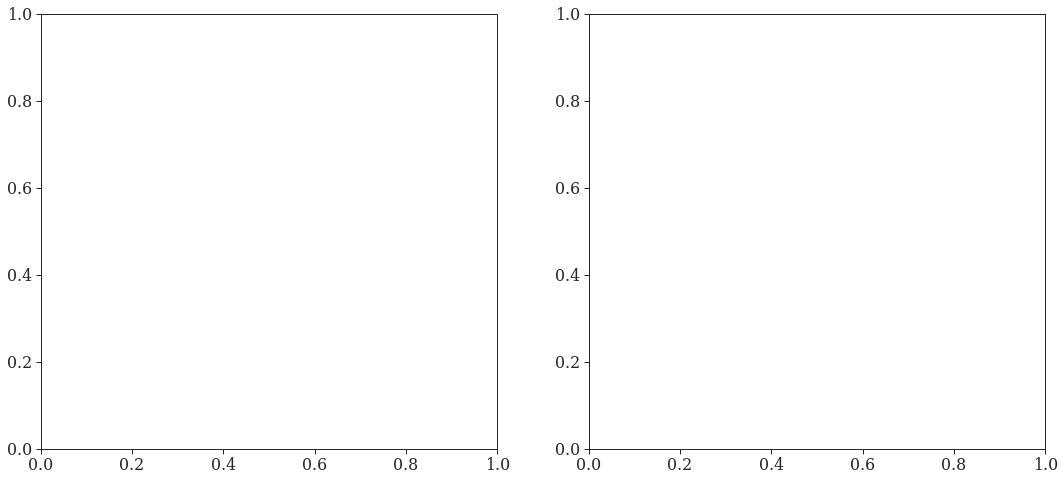

In [10]:
fig,ax = plt.subplots(ncols=2,figsize=(18,8))

ax[0].triplot(tri.points[:,0], tri.points[:,1], tri.simplices.copy())
ax[0].scatter(tri.points[:,0],tri.points[:,1],color='red')
ax[0].scatter(tri.points[cHullvertices][:,0],tri.points[cHullvertices][:,1],color='green')
# for i,pt in enumerate(tri.points):
#     ax[0].annotate('%i'%i,(pt[0]+0.1,pt[1]+0.1), fontsize=11)
ax[0].set_title('Full Grid (%i points)' %len(xy))    


ax[1].triplot(triNew.points[:,0], triNew.points[:,1], triNew.simplices.copy())
ax[1].scatter(triNew.points[:,0],triNew.points[:,1],color='red')
ax[1].scatter(triNew.points[cHullverticesNew][:,0],triNew.points[cHullverticesNew][:,1],color='green')
# for i in keepPts:
#     ax[1].annotate('%i'%i,(tri.points[i][0]+0.1,tri.points[i][1]+0.1), fontsize=11)
ax[1].set_title('Delaunay Trimmed Grid (%i points)' %len(newPts))    

plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(14,4))

ax[0].scatter(data['mhscp'],data['width'],c=yvalsNorm,s=25,cmap=cm, vmin=minValue,vmax=1.0,norm=LogNorm())
ax[0].set_title('Full Grid')

im = ax[1].scatter(data['mhscp'],data['width'],c=y_interpNorm,s=25,cmap=cm, vmin=minValue,vmax=1.0,norm=LogNorm())
ax[1].set_title('Delaunay Trimming')

# fig.colorbar(im, ax=ax)
plt.show()

In [ ]:
zlabel = 'width'
zpts = data[zlabel]
xlabels = [x for x in data.dtype.names if not 'ctau' in x.lower() and not x == valueLabel and not x == zlabel]
xpts = [list(x) for x in data[xlabels]]
ypts = data[valueLabel]
keepLines = trim1D(zpts,xpts,ypts,maxDiff=maxDiff,minY=minValue)

In [ ]:
newPts2 = xy[keepLines]
newVals2 = yvals[keepLines]
triNew2 = Delaunay(newPts2)
cHullverticesNew2 = list(set(triNew2.convex_hull.flatten()))
y_interp2 = griddata(newPts2,newVals2,tri.points)
diffs2 = np.where(yvals > minValue,np.abs(y_interp2-yvals)/yvals,maxDiff*y_interp2/minValue)
print('max diff=',diffs2.max())

In [ ]:
fig,ax = plt.subplots(ncols=2,figsize=(18,8))



ax[0].triplot(triNew.points[:,0], triNew.points[:,1], triNew.simplices.copy())
ax[0].scatter(triNew.points[:,0],triNew.points[:,1],color='red')
ax[0].scatter(triNew.points[cHullverticesNew][:,0],triNew.points[cHullverticesNew][:,1],color='green')
# for i in keepPts:
#     ax[0].annotate('%i'%i,(1.02*tri.points[i][0],1.02*tri.points[i][1]), fontsize=10)

ax[0].set_title('Delaunay Trimmed Grid (%i points)' %len(newPts))    



ax[1].triplot(triNew2.points[:,0], triNew2.points[:,1], triNew2.simplices.copy())
ax[1].scatter(triNew2.points[:,0],triNew2.points[:,1],color='red')
ax[1].scatter(triNew2.points[cHullverticesNew2][:,0],triNew2.points[cHullverticesNew2][:,1],color='green')
ax[1].set_title('1D Trimmed Grid (%i points)' %len(newPts2))    

plt.tight_layout()
plt.show()